In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Implementation of the **Deep Semantic Similarity Model** \
Based on the paper: *Learning Deep Structured Semantic Models for Web Search \(https://posenhuang.github.io/papers/cikm2013_DSSM_fullversion.pdf) using Clickthrough Data*



This code represents the implementation of a Deep Semantic Similarity Model, as described in the specified paper. The model is designed to learn structured semantic representations using query and documents pairs. The primary objective is to capture meaningful relationships and similarities within the data.

In [1]:
import json
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import Counter

import pandas as pd

from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn

import numpy as np
from torch.utils.data import random_split

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from torch.utils.data import random_split
import csv

import torch
from torch.utils.data import Dataset

from torch.optim import lr_scheduler
import re
import collections
import itertools

from tqdm import tqdm
from scipy.sparse import csr_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Reading Data from Corpus and Queries JSON Files

In [2]:
# Read jsonl files
def jsonl(path):
    data_ = []
    with open(path, 'r') as file:
        for line in file:
            data = json.loads(line)
            data_.append(data)
    return data_

In [3]:
corpus_path = '/content/drive/MyDrive/corpus.jsonl'
corpus = pd.DataFrame(jsonl(corpus_path))
corpus['text']=corpus['text'].astype(str)

queries_path = '/content/drive/MyDrive/queries.jsonl'
queries= pd.DataFrame(jsonl(queries_path))
queries['text']=queries['text'].astype(str)

In [4]:
corpus.head()

,_id,text
0,1867825,"After the invention of the cotton gin, cotton ..."
1,419610,"Timer has separate night and day outlets, whic..."
2,4614226,The rose-buying public still encounters a wide...
3,4108603,Map of Wendover (Aut) Airport. A detailed map ...
4,3744854,And as the poems Reapers and Cotton Song indic...


In [5]:
queries.head()

,_id,text,metadata
0,1185869,)what was the immediate impact of the success ...,{}
1,1185868,_________ justice is designed to repair the ha...,{}
2,597651,what color is amber urine,{}
3,403613,is autoimmune hepatitis a bile acid synthesis ...,{}
4,1183785,elegxo meaning,{}


Text Preprocessing using NLPurifier

In [ ]:
#pip install data-purifier

In [ ]:
#corpus_nl = Nlpurifier(corpus, "text")
#do not perform
#remove_html_tags(~80 sec)
#get_word_count(~40 sec)
#remove_emoticons(~)
#stemming ~600 sec

In [ ]:
#corpus_nl.df.head()
#corpus_nl.df['text']=corpus_nl.df['text'].apply(lambda x :x.split())

In [ ]:
#queries_nl = Nlpurifier(queries, "text")
#do not perform
#remove_html_tags(~80 sec)
#get_word_count(~40 sec)
#remove_emoticons(~)
#stemming ~600 sec

In [ ]:
#queries_nl.df.head()
#queries_nl.df['text']=queries_nl.df['text'].apply(lambda x :x.split())

**Extracting Text Pairs: Retrieving Corresponding Text from Query-Document Pairs IDs in Training Data**

In [6]:
def retrieve_pairs(corpus, queries, training_path):

    # Create dictionaries for faster lookup
    query_dict = dict(zip(queries['_id'], queries['text']))
    corpus_dict = dict(zip(corpus['_id'], corpus['text']))

    lines=0
    with open(training_path, 'r', newline='', encoding='utf-8') as tsvfile:

      reader = csv.DictReader(tsvfile, delimiter='\t')
      questions = []
      documents = []
      for row in reader:

          query_id = row['query-id']
          corpus_id = row['corpus-id']
          #lines+=1

          questions.append(query_dict[query_id])
          documents.append(corpus_dict[corpus_id])
          #if lines==500: #how to scale it
          #  break

    return questions, documents

tsv_file_path = '/content/drive/MyDrive/task1_train.tsv'
questions,documents=retrieve_pairs(corpus,queries,tsv_file_path)

In [8]:
len(documents)

532751

**Vectorizing Text: Applying CountVectorizer on Question-Document Pairs for Feature Extraction**


In [7]:
#Document-term sparse matrix
#vectorizer = CountVectorizer()
#vectorizer.fit(questions + documents)

#questions = vectorizer.transform(questions).toarray()     #queries-term sparse matrix
#documents = vectorizer.transform(documents).toarray()     #document-term sparse matrix

In [ ]:
#Faster approach
#questions_sparse = questions.tocoo()
#indices = torch.LongTensor([questions_sparse.row, questions_sparse.col])
#values = torch.FloatTensor(questions_sparse.data)
#shape = torch.Size(questions_sparse.shape)

#questions_tensor = torch.sparse.FloatTensor(indices, values, shape) #[training_dataset_len,vocab_size]

#documents_sparse = documents .tocoo()
#indices = torch.LongTensor([documents_sparse.row, documents_sparse.col])
#values = torch.FloatTensor(documents_sparse.data)
#shape = torch.Size(documents_sparse.shape)

#documents_tensor = torch.sparse.FloatTensor(indices, values, shape) #[training_dataset_len,vocab_size]\


**Word Hashing**

In [9]:
def gen_trigrams():

  """
      Generates all trigrams for characters from `trigram_chars`
  """

  trigram_chars="0123456789abcdefghijklmnopqrstuvwxyz"
  t3 = [''.join(x) for x in itertools.product(trigram_chars,repeat=3)] #len(words)>=3
  t2_start = ['#'+''.join(x) for x in itertools.product(trigram_chars,repeat=2)] #len(words)==2
  t2_end = [''.join(x)+'#' for x in itertools.product(trigram_chars,repeat=2)] #len(words)==2
  t1 = ['#'+''.join(x)+'#' for x in itertools.product(trigram_chars)] #len(words)==1
  trigrams = t3+t2_start+t2_end+t1
  vocab_size=len(trigrams)
  trigram_map=dict(zip(trigrams,range(0,vocab_size))) # trigram to index mapping, indices starting from 1
  return trigram_map

In [17]:

def sentences_to_bag_of_trigrams(sentences):
  """
      Converts a sentence to bag-of-trigrams
      `sentences`: list of strings
      `trigram_BOW`: return value, (len(sentences),len(trigram_map)) size array
  """
  trigram_map=gen_trigrams()
  #trigram_BOW=dok_matrix((len(sentences),len(trigram_map))) # one row for each sentence
  num_sentences = len(sentences)
  num_trigrams = len(trigram_map)
  rows = []
  cols = []
  data = []

  with tqdm(total=num_sentences, desc="Processing Sentences", unit="sentence") as pbar:

    for j,sent in enumerate(sentences):
      sent=re.sub(r"(\s)\s+", r"\1", sent) # reduce multiple whitespaces to single whitespace
      words=sent.split(' ')

      indices=collections.defaultdict(int)

      for word in words:
        word='#'+word+'#'
        for k in range(len(word)-2):
          trig=word[k:k+3]
          idx=trigram_map.get(trig, 0)
          indices[idx]=indices[idx]+1

      #for key,val in indices.items():
      #  trigram_BOW[j,key]=val

      for key, val in indices.items():
        rows.append(j)
        cols.append(key)
        data.append(val)
      pbar.update(1)

  trigram_BOW = csr_matrix((data, (rows, cols)), shape=(num_sentences, num_trigrams))
  return trigram_BOW

In [18]:
questions_hashing = sentences_to_bag_of_trigrams(questions)


Processing Sentences: 100%|██████████| 532751/532751 [00:18<00:00, 29424.30sentence/s]


In [19]:
document_hashing = sentences_to_bag_of_trigrams(documents)

Processing Sentences: 100%|██████████| 532751/532751 [02:36<00:00, 3407.79sentence/s]


***Randomly select either 4 negative documents or 4 non-relevant documents from the corpus, as the paper suggests***

In [26]:
questions_,rel_doc,n_rel_doc = [], [], []
with tqdm(total=questions_hashing.shape[0], desc="Processing Queries and Documents", unit="pair") as pbar:

  for query,doc in zip(questions_hashing,document_hashing):
    #non_rel_docs = [document_hashing[idx] for idx in np.random.randint(len(document_hashing),size=4)]

    non_rel_docs = [document_hashing[idx] for idx in np.random.randint(document_hashing.shape[0],size=4)]
    questions_.append(query)
    rel_doc.append(doc)
    n_rel_doc.append(non_rel_docs)
    pbar.update(1)

Processing Queries and Documents: 100%|██████████| 532751/532751 [05:45<00:00, 1542.98pair/s]


**Defining DSSM Dataset: Creating a Custom Class to Properly Retrieve and Organize Data for Deep Semantic Similarity Model Training**

In [88]:
class DSSM_Dataset(Dataset):
  def __init__(self,query,rel_doc,n_rel_doc):

    self.query = query
    self.rel_doc = rel_doc
    self.n_rel_doc = n_rel_doc

  def __len__(self):
    return len(self.query)

  def __getitem__(self,idx):
    query     = torch.FloatTensor(np.array(self.query[idx].toarray(),dtype=np.float32))
    rel_doc   = torch.FloatTensor(np.array(self.rel_doc[idx].toarray(), dtype=np.float32))
    #n_rel_doc = torch.FloatTensor(np.array(self.n_rel_doc[idx], dtype=np.float32))
    n_rel_doc_dense = [np.array(mat.toarray(), dtype=np.float32) for mat in self.n_rel_doc[idx]]
    n_rel_doc_tensor = torch.stack([torch.FloatTensor(mat) for mat in n_rel_doc_dense]).squeeze(1)
    return query,rel_doc,n_rel_doc_tensor


Data Splitting and DataLoader Setup: \
Partitioning the Dataset and Configuring DataLoaders for Training and Evaluation with Batch Size

In [89]:
TRAIN_SIZE = 0.8
BATCH_SIZE = 32
total = len(questions_)
train_size = int(total * TRAIN_SIZE)
eval_size = total - train_size

dssm_dataset = DSSM_Dataset(questions_, rel_doc, n_rel_doc)

In [92]:
train_dataset, eval_dataset = random_split(
    dataset=dssm_dataset,
    lengths=[train_size, eval_size],
    generator=torch.Generator().manual_seed(0)
)

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_iterator = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)
batch_num = len(train_iterator)

####                                          **DSSM Model Siamese neural network**


Model Definition: Creating the DSSM Model for Semantic Similarity

This code defines the DSSM model, which consists of two branches for processing queries and documents. The model uses a multilayer perceptron (MLP) architecture with sigmoid activation, dropout layers, and Tanh activation for generating 128-dimensional embeddings. The cosine similarity is employed to measure relevance, and the softmax function is applied to obtain posterior probabilities for relevant documents.

The DSSM_Model class is instantiated with parameters for input features, gamma (optional), and device. The forward method takes query (q), positive document (p), and a list of negative samples (ns) as input, returning the softmax probabilities for relevant documents

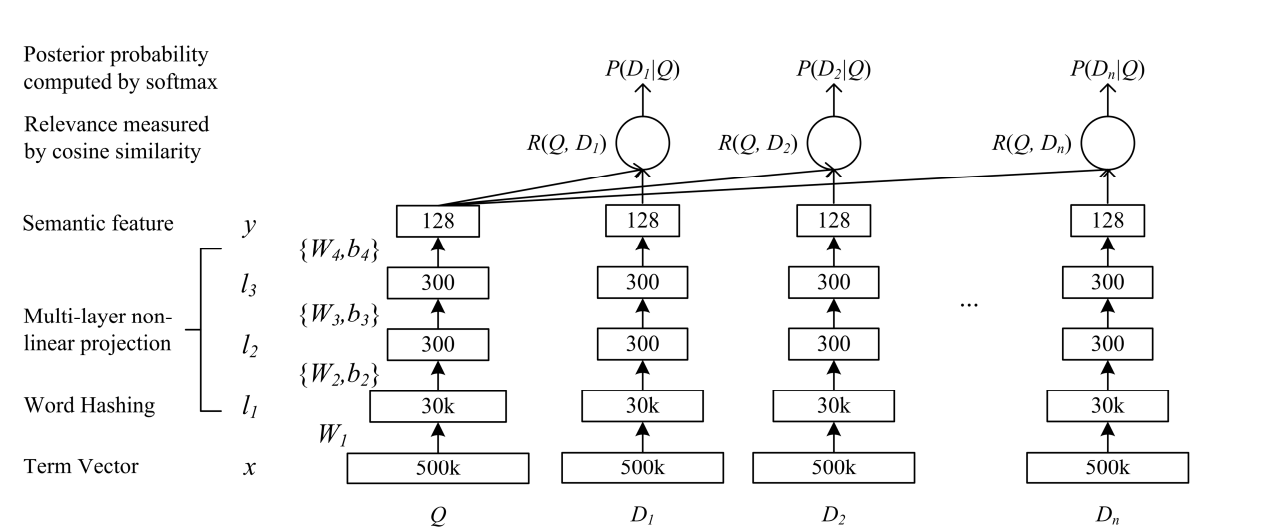

In [107]:
#define the DSSM model
import torch.nn.functional as F

class DSSM_Model(nn.Module):

  def __init__(self, in_features, gamma=None, device='cpu'):

    super(DSSM_Model, self).__init__()

    self.in_features = in_features
    self.device = device
    self.gamma=gamma

    # Create MLP layers
    self.query_ = nn.Sequential(
        nn.Linear(self.in_features, 300),
        nn.Linear(300, 300),
        nn.Sigmoid(),
        nn.Dropout(0.1),
        nn.Linear(300, 300),
        nn.Sigmoid(),
        nn.Dropout(0.1),
        nn.Linear(300, 128),
        nn.Tanh()
    )

    self.doc_ = nn.Sequential(
        nn.Linear(self.in_features, 300),
        nn.Linear(300, 300),
        nn.Sigmoid(),
        nn.Dropout(0.1),
        nn.Linear(300, 300),
        nn.Sigmoid(),
        nn.Dropout(0.1),
        nn.Linear(300, 128),
        nn.Tanh()
    )

    self.to(self.device)

  def forward(self, query, relevant, non_rel):

    query = F.normalize(query, p=2, dim=-1)
    relevant = F.normalize(relevant, p=2, dim=-1)
    non_rel = F.normalize(non_rel, p=2, dim=-1)

    out_query = self.query_(query)                                #[batch_size,out_features/128]
    out_relevant = self.doc_(relevant)                                  #[batch_size,out_features/128]
    out_non_rel = [self.doc_(n) for n in non_rel.permute(1, 0, 2)]  # list of [batch_size,out_features/128]

    # Relevance measured by cosine similarity
    cos_query_rel = F.cosine_similarity(out_query, out_relevant, dim=1).unsqueeze(1)
    cos_query_non_rel = [F.cosine_similarity(out_query, out_n, dim=1).unsqueeze(1) for out_n in out_non_rel]

    cos_qrn = [cos_query_rel, *cos_query_non_rel]                     #list of cosine similarities between the query and the positive + 4 negatives examples for the entire batch
    cos_uni = torch.cat(cos_qrn, 1)                  # tensor[batch_size, 5(non_rel+rel)]
    # posterior probability computed by softmax
    softmax_qp = F.softmax(cos_uni, dim=1)[:, 0]     #(batch_size) the softmax probabilities only for the relevant documents.

    return softmax_qp

**Loss function**


Loss Function Definition: Custom Loss for Training the DSSM Model \
The loss function $\mathcal{L}$ is defined as:


$ \mathcal{L} = -\log \left( \frac{\exp(\text{cosine}(\mathbf{q}, \mathbf{p}))}{\sum_{\mathbf{n} \in \mathcal{N}} \exp(\text{cosine}(\mathbf{q}, \mathbf{n}))} \right)$

where:
- $\mathbf{q}$ represents the query,
- $\mathbf{p}$ is the positive document, and
- $\mathbf{n}$ is a negative sample from the set $\mathcal{D}$ of all documents.

The objective of the loss function is to enhance the likelihood of clicked documents given queries in the training process. Consequently, we will also consider the posterior probabilities related to positive pairs.



In [108]:
def criterion(softmax_probabilities):
  return -torch.log(torch.prod(softmax_probabilities)) #-torch.sum(torch.log(softmax_probabilities))

**Training Loop for Deep Semantic Similarity Model: Updating Model Parameters Across Epochs**

In [ ]:

def training_loop(model,epochs,train_,eval_,optimizer,scheduler,device='cpu'):

  for epoch in range(epochs):

    model.train()
    batch_idx = 0
    train_loss = []

    for query, relevant, non_relevant in train_:

      query = query.to(device)
      relevant = relevant.to(device)
      non_relevant = non_relevant.to(device)

      optimizer.zero_grad()

      softmax_qp = model.forward(query,relevant, non_relevant)

      loss = criterion(softmax_qp)

      loss.backward()

      optimizer.step()

      train_loss.append(loss.item())
      batch_idx += 1
      if batch_idx % 5 == 0:
        avg_train_loss = np.average(train_loss[-5:])
        print(f"Epoch {epoch + 1}/{epochs}, Batch {batch_idx}/{len(train_)} - Training Loss: {avg_train_loss:.5f}")

    average_training_loss= np.average(train_loss)
    print(f"Epoch {epoch+1}/{epoch} - Training Loop : {average_training_loss:.5f}")

    model.eval()

    eval_loss = []

    for query, relevant, non_relevant in eval_:

      query = query.to(device)
      relevant = relevant.to(device)
      non_relevant = non_relevant.to(device)

      softmax_qp = model.forward(query, relevant, non_relevant)
      loss = criterion(softmax_qp)
      eval_loss.append(loss.item())
    avg_eval_loss = np.average(eval_loss)
    print(f"Epoch {epoch+1}/{epoch} - Validation Loop: {avg_eval_loss:.5f}")


#define input_Features size
#in_features = len(vectorizer.get_feature_names_out()) #vocab_size
in_features = len(gen_trigrams())
model = DSSM_Model(in_features) #create the model

#initialize the wights and bias
weight_p, bias_p = [], []
for param_name,param in model.named_parameters():
  if 'bias' in param_name:
    bias_p += [param]
  else:
    weight_p += [param]

Model Training with Custom Optimizer: Configuring Learning Rate, Weight Decay, and Scheduler for a Deep Semantic Similarity Model

In [101]:
learning_rate = 0.01

optimizer = torch.optim.Adam([{'params': weight_p, 'weight_decay': 0},
                                      {'params': bias_p, 'weight_decay': 0}], lr= learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=1)

In [ ]:
EPOCHS = 3
training_loop(model,EPOCHS,train_iterator,eval_iterator,optimizer,scheduler)

**Model Testing: Evaluating the Performance of the Trained Deep Semantic Similarity Model on Test Data**

In [30]:
def retrieve_testing_questions(queries, testing_path):

    # Create dictionaries for faster lookup
    query_dict = dict(zip(queries['_id'], queries['text']))

    with open(testing_path, 'r', newline='', encoding='utf-8') as tsvfile:

      reader = csv.DictReader(tsvfile, delimiter='\t')
      questions = []
      for row in reader:
          query_id = row['query-id']
          questions.append(query_dict[query_id])
    return questions

tsv_testing_path = '/content/drive/MyDrive/task1_test.tsv'
testing_questions = retrieve_testing_questions(queries,tsv_testing_path)

In [40]:
#Just basic function not optimized
def encode(model,text,device='cpu'):

  model.eval()
  vectors = sentences_to_bag_of_trigrams(text)
  with torch.no_grad():
    vectors = torch.FloatTensor(vectors).to(device)
  vectors = model.query_(vectors).tolist()
  return vectors

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

document_1 = 'Injunction Law and Legal Definition. Injunctive relief consists of a court order called an injunction, requiring an individual to do or not do a specific action. It is an extraordinary remedy that courts utilize in special cases where preservation of the status quo or taking some specific action is required in order to prevent possible injustice.'

vectors = encode(model,[testing_questions[0], document_1])
score = cosine_similarity([vectors[0]], [vectors[1]])
print('score:', score[0][0])


score: 0.999999932349992


PREVIOUS IMPLEMENTATIONS

In [ ]:
#import the stopword list from the spacy library
#Counter appliation in order to improve the running

#sp = spacy.load('en_core_web_sm')
#spacy_stopwords = sp.Defaults.stop_words
#stopwords_dict = Counter(spacy_stopwords)
#lemmatizer =WordNetLemmatizer()

#spacy_stopwords = list(sp.Defaults.stop_words)
#stop_words = spacy_stopwords + ['im', 'dont','dunno', 'cant',"'s", 'u', 'x','user','url','rt','lol', '<user>', '<url>']

In [ ]:

'''
#cleaning "pipeline"
def clean_data(text, stopwords, lemmatization):

      #perform casefolding
      text =text.casefold()
      #remove different tags for instance "<user>,<url>"
      text = re.sub('<[^<]+?>','', text)
      #remove digits
      text = ' '.join(text_ for text_ in text.split() if not text_.isdigit())
      #remove punctuations
      text = ' '.join(text_ for text_ in text.split() if text_ not in string.punctuation)
      #remove the tokens length less than 2
      text = ' '.join(text_ for text_ in text.split() if len(text)>2)

      if lemmatization :
          #perform lemmatization
          text = ' '.join(lemmatizer.lemmatize(text_)  for text_ in text.split() )

      if stopwords:
          #remove the stopwords
          text = ' '.join([word for word in text.split() if word not in stopwords_dict])
      return text
'''
#Load the data and run the preprocessor pipeline
'''
class Preprocessor:
    def __init__(self):
        """Init function
        """
    def load_data(self,path,preprocessed=True):
        DIRECTORY1 = path

        #import the data
        data= pd.DataFrame(jsonl(path))
        data['text']=data['text'].astype(str)

        #data.dropna(subset = ["text"], inplace=True)
        data['text']=data['text'].apply(lambda x : clean_data(x, stopwords=True,lemmatization=True))

        #remove empty lines if any
        data.dropna(subset = ["text"], inplace=True)

        return data
'''

In [ ]:
#corpus_pre = Preprocessor.load_data(preprocessed=True,'/content/drive/MyDrive/corpus.jsonl')
#queries_pre = Preprocessor.load_data(preprocessed=True,'/content/drive/MyDrive/queries.jsonl')

*Dataset*

In [47]:

'''
queries = queries.set_index('_id')['text'].to_dict()
corpus = corpus.set_index('_id')['text'].to_dict()
#up to 94% in corpus have 100 tokens and 99% 127 tokens
#and the max tokens in queries is 38 tokens

import csv

#we have corpus/documents id,text and queries id,text als the training dataset query_id,doc_id
def retrieve_pairs(corpus_dic,queries_dic,training_path):

  tsv_file_path = '/content/drive/MyDrive/task1_train.tsv'
  with open(tsv_file_path, 'r', newline='', encoding='utf-8') as tsvfile:

    reader = csv.DictReader(tsvfile, delimiter='\t')
    training_pairs = []
    for row in reader:
      training_pairs.append((queries.get(row['query-id']),corpus.get(row['corpus-id'])))

  return training_pairs   # list of [(query/string,corpus/string)]


#With embeddings
class DSSM_Dataset(Dataset):

  def __init__(self, dataset, max_length):

    self.max_seq_length = max_length
    self.dssm_dataset = self.padding_(dataset,self.max_seq_length)
    self.vocabulary = self.get_vocabulary(dataset)

    #word to index dictionaries
    self.word2index = { word : idx  for idx,word in enumerate(self.vocabulary) }
    self.index2word = { idx  : word for idx,word in enumerate(self.vocabulary) }


  def get_vocabulary(self,train_dataset):

    #all unique words of our corpus+queries
    vocabulary = ['<pad>']
    vocabulary += sorted(set([word for pair in train_dataset for sentence in pair for word in sentence.split()]))
    return vocabulary

  @staticmethod
  def padding_(dataset,max_length):

    prepared_dataset=[]
    for sample in dataset:
      query,corpus = sample

      query_tokens=query.split()
      query_len=len(query_tokens)

      corpus_tokens=corpus.split()
      corpus_len=len(corpus_tokens)

      if query_len < max_length:  #query can't be larger than 130 tokens
        query=" ".join(query_tokens+['<pad>']*(max_length-query_len))

      if corpus_len < max_length:
        corpus=" ".join(corpus_tokens+['<pad>']*(max_length-corpus_len))
      else:
        #todo cut the corpus as the max_length
        corpus=" ".join(corpus_tokens[:max_length])

      prepared_dataset.append((query,corpus))

    return prepared_dataset


  def __len__(self):
    return len(self.dssm_dataset)

  def __getitem__(self,idx):

    query_tokens  = self.dssm_dataset[idx][0].split()
    corpus_tokens = self.dssm_dataset[idx][1].split()

    #return the input_ids for (query,corpus) pair
    query_input_ids =  [self.word2index.get(token,self.word2index['<pad>'])  for token in query_tokens]
    corpus_input_ids = [self.word2index.get(token,self.word2index['<pad>'])  for token in corpus_tokens]

    return torch.tensor(query_input_ids),torch.tensor(corpus_input_ids)

corpus_queries_dataset = retrieve_pairs(corpus,queries,'/content/drive/MyDrive/task1_train.tsv')
MAX_LENGTH = 130

dssm_dataset = DSSM_Dataset(corpus_queries_dataset , MAX_LENGTH)

'''